In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress


file_path = 'Jumbo I_V Sweep [WF01_251203_#1_Jumbo_L0(1) ; 12_12_2025 9_51_57 AM].csv'
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

for i, line in enumerate(lines):
    if any(col.strip().startswith('DataValue') for col in line.split(',')):
        header_row = i - 2
        break
df = pd.read_csv(file_path,sep = ',', header = header_row)

df = df.iloc[:,1:]
df.columns = df.columns.str.strip()

df.head(10)

,VG,VD,IG,ID,IS
0,-3.000,0.1,-2.774400e-11,6.593000e-12,2.793000e-12
1,-2.975,0.1,-5.134000e-12,2.547000e-12,1.545000e-12
2,-2.950,0.1,-2.909000e-12,1.539000e-12,1.122000e-12
3,-2.925,0.1,-2.327000e-12,1.175000e-12,7.680000e-13
4,-2.900,0.1,-1.994000e-12,9.620000e-13,5.470000e-13
5,-2.875,0.1,-1.458000e-12,8.200000e-13,5.660000e-13
6,-2.850,0.1,-1.019000e-12,6.160000e-13,5.460000e-13
7,-2.825,0.1,-1.064000e-12,4.650000e-13,4.210000e-13
8,-2.800,0.1,-1.155000e-12,5.120000e-13,3.080000e-13
9,-2.775,0.1,-9.330000e-13,5.070000e-13,3.350000e-13


In [9]:
## data 제대로 들어왔는지 확인

In [26]:
df['ID'] = df['ID'].abs()
df['ID'] = np.clip(df['ID'], 1e-16, None)

df.value_counts()
df.describe()
row_counts = df.shape[0]

for i in df.columns:
    empty = df[i].isna().sum()
    print(f'{i} column에서 빈값은 {empty}개임.')

VG column에서 빈값은 0개임.
VD column에서 빈값은 0개임.
IG column에서 빈값은 0개임.
ID column에서 빈값은 0개임.
IS column에서 빈값은 0개임.


In [11]:
# graph plot

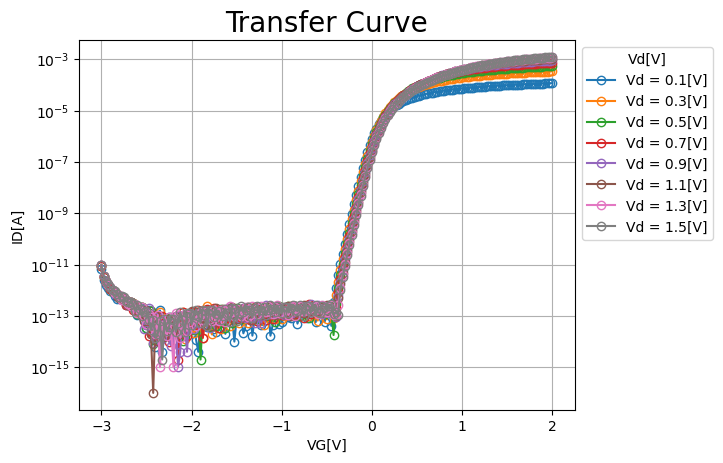

In [27]:
fig, ax  = plt.subplots()
for VD, g in df.groupby('VD'):
    plt.semilogy(g['VG'],g['ID'],marker = 'o',markerfacecolor = 'none',label = f'Vd = {VD}[V]')

ax.set_xlabel('VG[V]')
ax.set_ylabel('ID[A]')
ax.set_title('Transfer Curve', fontsize = 20)
ax.legend(title = 'Vd[V]',bbox_to_anchor = (1,1),loc = 'upper left',fontsize = 10)
ax.grid(True)


In [13]:
# Vth 구하기

In [ ]:
target1 = -10                               # log(ID) = -10이 타겟임(vth 산출용)
target2 = -9                                # SS 산출용
vth_by_vd_10 = {}  # VD별 Vth 저장
vth_by_vd_9 = {}  # VD별 Vth 저장
for vd, g in df.groupby('VD'):              # 앞에 있는 vd는 df.groupby('VD')의 key인 'VD'를 받는것이고 뒤에 있는 g는 key 'VD'에 해당하는 값을 받는다.
    g = g.sort_values('ID')

    VG = g['VG'].to_numpy()                 # VG column을 단순 array로 변환
    ID = g['ID'].to_numpy()                 # ID column을 단순 array로 변환

    # log10(|ID|) 계산: 0은 로그 불가 → 아주 작은 값으로 클리핑
    absID = np.abs(ID)
    absID = np.clip(absID, 1e-300, None)   # underflow 방지
    logI = np.log10(absID)

     # ===== 3) target 교차 구간 탐색 + 선형 보간 =====
    diff1 = logI - target1
    diff2 = logI - target2
    cross_idx_10 = np.where(diff1[:-1] * diff1[1:] <= 0)[0]  # target을 사이에 두는 인접 점(★★★★★★★★★★★★ np.where(condition,True,False))
    cross_idx_9 = np.where(diff2[:-1] * diff2[1:] <= 0)[0] 

    if len(cross_idx_10) == 0:
        vth_by_vd_10[vd] = np.nan
        continue
    if len(cross_idx_9) == 0:
        vth_by_vd_9[vd] = np.nan
        continue
    # 첫 번째 crossing 사용 (원하면 마지막 crossing: cross_idx[-1])
    i1 = cross_idx_10[0]
    i2 = cross_idx_9[0]

    x0, x1 = VG[i1], VG[i1+1]
    y0, y1 = logI[i1], logI[i1+1]

    z0, z1 = VG[i2], VG[i2+1]
    t0, t1 = logI[i2], logI[i2+1]    

    # 분모 0 방지
    if y1 == y0:
        vth_10 = np.nan
    else:
        vth_10 = x0 + (target1 - y0) * (x1 - x0) / (y1 - y0)

    vth_by_vd_10[vd] = vth_10
    
    # 분모 0 방지
    if t1 == t0:
        vth_9 = np.nan
    else:
        vth_9 = z0 + (target2 - t0) * (z1 - z0) / (t1 - t0)

    vth_by_vd_9[vd] = vth_9
    
# ===== 5) VD별 Vth 출력 =====
print(f"Vth @ log10(|ID|) = {target1} (by VD)")
for vd in sorted(vth_by_vd_10.keys()):
    print(f"VD={vd}: Vth={vth_by_vd_10[vd]:.2f}")

    # ===== 6) VD별 SS 계산 =====
ss_by_vd = {}  # VD별 SS 저장 (mV/dec)

for vd in vth_by_vd_10.keys():
    vg_at_10 = vth_by_vd_10.get(vd, np.nan)  # log|ID|=-10에서 VG
    vg_at_9  = vth_by_vd_9.get(vd, np.nan)   # log|ID|=-9에서 VG

    # 둘 중 하나라도 NaN이면 SS도 NaN
    if np.isnan(vg_at_10) or np.isnan(vg_at_9):
        ss_by_vd[vd] = np.nan
    else:
        ss_v_per_dec = (vg_at_9 - vg_at_10) / (target2 - target1)  # 여기서는 /1이라 동일하지만 일반식으로 작성
        ss_by_vd[vd] = ss_v_per_dec * 1000  # mV/dec

# ===== 7) VD별 SS 출력 =====
print(f"SS (mV/dec) using log10(|ID|)={target1} to {target2} (by VD)")
for vd in sorted(ss_by_vd.keys()):
    print(f"VD={vd}: SS={ss_by_vd[vd]:.2f}")



Vth @ log10(|ID|) = -10 (by VD)
VD=0.1: Vth=-0.29
VD=0.3: Vth=-0.27
VD=0.5: Vth=-0.26
VD=0.7: Vth=-0.26
VD=0.9: Vth=-0.25
VD=1.1: Vth=-0.24
VD=1.3: Vth=-0.24
VD=1.5: Vth=-0.24
SS (mV/dec) using log10(|ID|)=-10 to -9 (by VD)
VD=0.1: SS=65.23
VD=0.3: SS=64.95
VD=0.5: SS=64.84
VD=0.7: SS=64.70
VD=0.9: SS=64.71
VD=1.1: SS=64.70
VD=1.3: SS=64.71
VD=1.5: SS=64.70
